In [1]:
# 
root = "/home/shi/WorkSpace/projects/scMultiNet_Data/"
data_loc = root + "Step_2_data/Cook/classification/train/"
#root = "/home/shi/WorkSpace/projects/scLLM_workspace/Outputs/Figures/Figure_top_genes_multinet/multi_fuse_128/val/"
feature_locs = [
    "cls0.pkl",
    "cls1.pkl",
    "cls2.pkl",
    "cls3.pkl",
    "cls4.pkl",
]

raw_data_loc = root+ "Step_1_data/Dataset_cook/TrVal_dataset_PC_TGFb_GTlabel5.pkl"
save_folder = root + "/Step_5_data/figures/"

fuse_model_ckpt = root + "Step_2_data/Cook/classification/ckpt/model_0.9019531292560845.ckpt"

code_loc = "/home/shi/WorkSpace/projects/scMultiNet_workspace/"

vocab = code_loc + "/Experiment/support_data/vocab_16k.json"
# read vocab
import json
with open(vocab,"r") as f:
    gene_names = json.load(f)

In [2]:
# visualisation parameters
# 定义类别和颜色
label_order = ["0d", "8h", "1d", "3d", "7d"]
colors = ['#0c1b33', '#437c90', '#8b212c', '#f55141', '#ffa360']

# 创建标签到颜色的映射
label_color_map = {label: color for label, color in zip(label_order, colors)}

In [3]:
# load model and calc features
import torch
import torch.nn.functional as F
import sys
DIM = 128


import torch.nn as nn
class FuseNet(nn.Module):
    def __init__(self,in_dim=128*5, dropout = 0., h_dim = 128, out_dim = 5, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        if out_key == "fc1":
            return x

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        if out_key == "fc2":
            return x
        x = self.fc3(x)
        if out_key == "all":
            return x
        else:
            raise ValueError("out_key must be one of 'fc1', 'fc2', 'all'")
    
# 从文件夹中读取所有类的feature matrix
import pickle
import numpy as np

#-->train
train_feat_list = []
for i in range(len(feature_locs)):
    with open(data_loc+feature_locs[i],"rb") as f:
        [feat,label] = pickle.load(f)
        train_feat_list.append(feat)
train_label = label
print(len(train_feat_list),train_feat_list[0].shape,train_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
train_feat = np.concatenate(train_feat_list,axis=1) 
train_feat = torch.from_numpy(train_feat).float()
train_label = torch.from_numpy(train_label).long() 
# label from [sample_nb,1] -> [sample_nb,class_nb]
train_label = torch.zeros(train_label.shape[0],5).scatter_(1,train_label,1)


# get Dataset and DataLoader
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(train_feat,train_label)

trainloader = DataLoader(trainset,batch_size=DIM,shuffle=False)


# get model
model = FuseNet(in_dim=DIM*5, dropout = 0., h_dim = DIM, out_dim = 5, )

ckpt_folder =fuse_model_ckpt

# load model
model.load_state_dict(torch.load(ckpt_folder))

# get features
model.eval()
feat_layer = "fc1"
all_feat = []
all_feat2 = []
all_label = []
all_pred = []
with torch.no_grad():
    for data in trainloader:
        inputs,label = data
        feat = model(inputs,out_key=feat_layer)
        all_feat.append(feat)
        all_label.append(label)
        all_feat2.append(inputs)
        pred = model(inputs,out_key="all")
        prob = F.softmax(pred,dim=1)
        y_hat = torch.argmax(prob,dim=1)
        all_pred.append(y_hat)
embedding = torch.cat(all_feat,dim=0).detach().numpy()
labels = torch.cat(all_label,dim=0).detach().numpy()
preds = torch.cat(all_pred,dim=0).detach().numpy()
all_feat2 = torch.cat(all_feat2,dim=0).detach().numpy()
print(embedding.shape,labels.shape,preds.shape)

5 (5881, 128) (5881, 1)
(5881, 512) (5881, 5) (5881,)


In [4]:
labels = np.argmax(labels,axis=1)
print(labels)

[0 0 2 ... 2 1 0]


In [5]:
import sys
sys.path.append(code_loc)
import scLLM

# 数据集读取
import dill
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [dataset_1,_,_,label_dict] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(dataset_1))

print(label_dict)
# reverse label_dict
rev_label_dict = {v:k for k,v in label_dict.items()}
print(rev_label_dict)


trainset size:  5881
{'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}
{0: '3d', 1: '7d', 2: '1d', 3: '8h', 4: '0d'}


In [6]:
import scanpy as sc
# 第 1 步: 读取数据
exp_raw_data = dataset_1.data

remove_label_value = label_dict["0d"]
root_label_value = label_dict["8h"]
# 第 2 步：数据准备
adata_raw = sc.AnnData(X=exp_raw_data)
adata_raw.var_names = [name for name, _ in sorted(gene_names.items(), key=lambda x: x[1])]
adata_raw.obs['labels'] = labels
adata_raw.obsm['X_emb'] = embedding  # embedding 是嵌入矩阵



In [7]:
# 删掉 labels == "0d" 的细胞 和对应的embedding
# 筛选出不等于 '0d' 的细胞
mask = adata_raw.obs['labels'] != remove_label_value
adata = adata_raw[mask]

In [8]:
# 第 3 步：Scanpy 分析

# 用嵌入矩阵计算邻居图
# 第 3 步：Scanpy 分析
import phate
# 使用 PHATE 计算嵌入
phate_op = phate.PHATE()
phate_emb = phate_op.fit_transform(adata.obsm['X_emb'])
# 将 PHATE 嵌入结果存储到 AnnData 对象中
adata.obsm['X_phate'] = phate_emb

# 使用 PHATE 嵌入计算邻居图
sc.pp.neighbors(adata, use_rep='X_phate')



Calculating PHATE...
  Running PHATE on 4747 observations and 512 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.54 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.53 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 1.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.12 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.95 seconds.
  Calculated landmark operator in 3.40 seconds.
  Calculating optimal t...
    Automatically selected t = 34
  Calculated optimal t in 0.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.39 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.18 seconds.
Calculated PHATE in 7.43 seconds.


/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:108

In [9]:


# 运行 DPT 分析
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.flatnonzero(adata.obs['labels'] == root_label_value)[0]
sc.tl.dpt(adata)

In [10]:
l_list = adata.obs['labels'].to_list()
l_list = [rev_label_dict[i] for i in l_list]
adata.obs['GT'] = l_list


In [13]:
remove_label_value

4

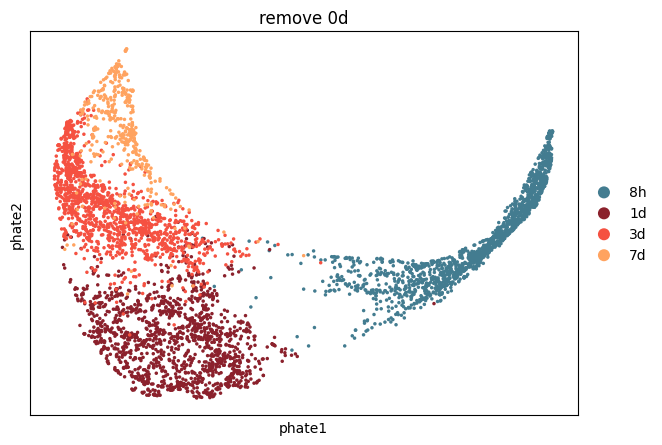

In [14]:
# 第 4 步：结果分析和可视化
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 第 4 步：结果分析和可视化
# 创建一个从红色到蓝色的颜色映射
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "blue"])

# 确保GT列的数据类型是category
adata.obs['GT'] = adata.obs['GT'].astype('category')

new_label = []
new_color = []
for l,c in zip(label_order,colors):
    if l != rev_label_dict[remove_label_value]:
        new_label.append(l)
        new_color.append(c)
# 确保类别顺序
adata.obs['GT'] = adata.obs['GT'].cat.reorder_categories(new_label)

# 将颜色映射到GT类别并保存到adata.uns中
adata.uns['GT_colors'] = new_color
sc.settings.figdir = save_folder
# 在 PHATE 嵌入上进行 DPT 可视化
sc.pl.scatter(adata, basis='phate', color=["GT"], title='remove 0d', save="_remove_0d.pdf")



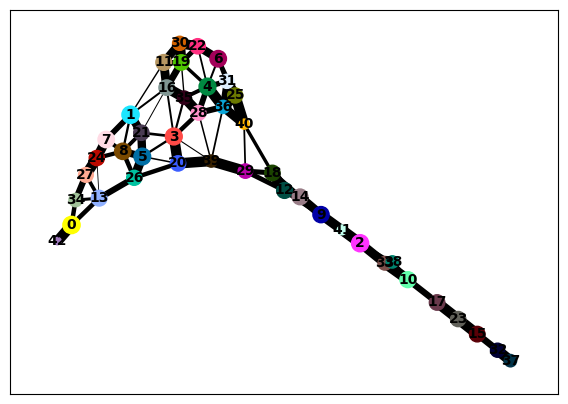

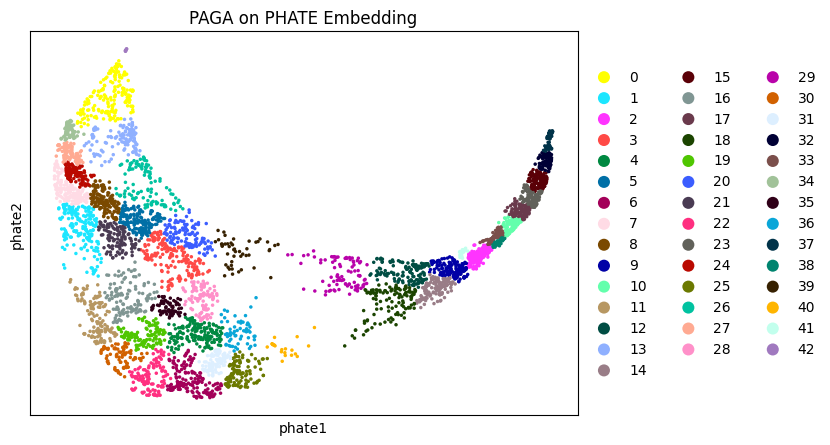

In [15]:
# PAGA 分析
# 执行聚类
sc.tl.leiden(adata)

# 计算 PAGA 图
sc.tl.paga(adata)

# 第 4 步：结果分析和可视化
# 可视化 PAGA 图
sc.pl.paga(adata, plot=True)  # 选择 plot=True 来直接绘制 PAGA 图
# 可视化 PHATE 降维结果，标记 Leiden 聚类
sc.pl.scatter(adata, basis='phate', color='leiden', title='PAGA on PHATE Embedding')

In [16]:
import scFates as scf
scf.tl.curve(adata,Nodes=25,use_rep="X_phate",ndims_rep=2,)

inferring a principal curve --> parameters used 
    25 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


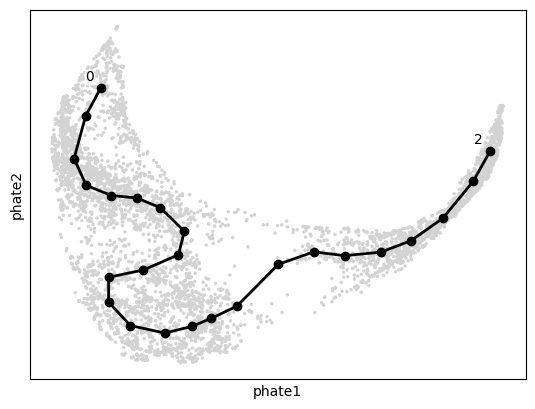

In [17]:
scf.pl.graph(adata,basis="phate",)

node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


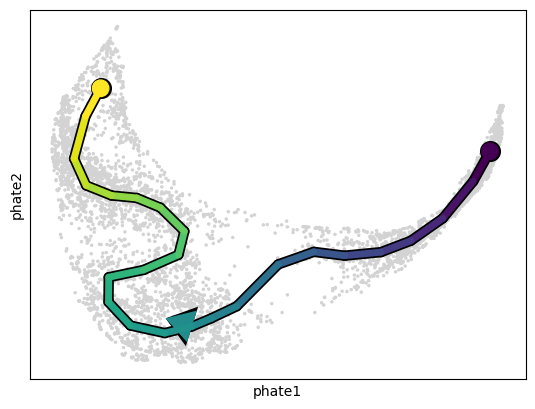

In [19]:
scf.tl.root(adata,2)
scf.tl.pseudotime(adata,n_jobs=1,n_map=1,seed=42)
scf.pl.trajectory(adata,basis="phate",arrows=True,arrow_offset=3)